In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.0 MB/s eta 0:00:00


In [2]:
import timm
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from typing import List, Tuple, Dict
import random

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a strong seed
set_seed(42)

In [4]:
import os
import zipfile

zip_path = "/content/Dropped-Dataset.zip"
extract_path = "/content/Dataset2"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Constants
NUM_CLIENTS = 3
NUM_ROUNDS = 12
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASS_NAMES = ['Healthy', 'Moderate', 'Severe']
BASE_DIR = "/content/Dataset2/archive"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, file_list=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = CLASS_NAMES
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        if file_list is None:
            self.file_list = []
            for class_name in self.classes:
                class_path = os.path.join(root_dir, class_name)
                if os.path.exists(class_path):
                    files = [os.path.join(class_name, f) for f in os.listdir(class_path)
                            if f.endswith(('.png', '.jpg', '.jpeg'))]
                    self.file_list.extend(files)
        else:
            self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.file_list[idx].split('/')[0]]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Data transformations
def create_transforms(is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [16]:
# Model definitions
class InceptionResNetV2Model(nn.Module):
    def __init__(self):
        super(InceptionResNetV2Model, self).__init__()
        self.base_model = timm.create_model('inception_resnet_v2', pretrained=True)
        num_features = self.base_model.classif.in_features  # Access the final fully connected layer
        self.base_model.classif = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        return self.base_model(x)

In [9]:
def create_client_shards():
    """Create client shards by dividing data among clients."""
    class_dirs = {}
    for class_name in CLASS_NAMES:
        class_path = os.path.join(BASE_DIR, 'train', class_name)
        image_files = [os.path.join(class_name, f) for f in os.listdir(class_path)
                      if f.endswith(('.png', '.jpg', '.jpeg'))]
        class_dirs[class_name] = image_files

    client_data = [[] for _ in range(NUM_CLIENTS)]
    client_sample_counts = [0] * NUM_CLIENTS

    for class_name, files in class_dirs.items():
        np.random.shuffle(files)
        files_per_client = len(files) // NUM_CLIENTS

        for client_idx in range(NUM_CLIENTS):
            start_idx = client_idx * files_per_client
            end_idx = start_idx + files_per_client if client_idx < NUM_CLIENTS - 1 else len(files)
            client_files = files[start_idx:end_idx]
            client_data[client_idx].extend(client_files)
            client_sample_counts[client_idx] += len(client_files)

    return client_data, client_sample_counts

In [10]:
def create_dataloaders(client_shards, client_sample_counts):
    """Create dataloaders for each client's shard."""
    train_transform = create_transforms(is_training=True)
    client_loaders = []

    for shard in client_shards:
        dataset = CustomImageDataset(
            os.path.join(BASE_DIR, 'train'),
            file_list=shard,
            transform=train_transform
        )
        loader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        client_loaders.append(loader)

    return client_loaders

In [11]:
def load_validation_test_data():
    """Load validation and test data."""
    val_transform = create_transforms(is_training=False)

    val_dataset = CustomImageDataset(
        os.path.join(BASE_DIR, 'val'),
        transform=val_transform
    )
    test_dataset = CustomImageDataset(
        os.path.join(BASE_DIR, 'test'),
        transform=val_transform
    )
    autotest_dataset = CustomImageDataset(
        os.path.join(BASE_DIR, 'auto_test'),
        transform=val_transform
    )

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    autotest_loader = DataLoader(autotest_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return val_loader, test_loader, autotest_loader

In [12]:
def client_update(model, dataloader, optimizer, criterion):
    """Train the model on client data."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = correct / total
    return model.state_dict(), accuracy

In [13]:
def weighted_average_weights(weights_list: List[Dict[str, torch.Tensor]],
                           sample_counts: List[int]) -> Dict[str, torch.Tensor]:
    """Compute weighted average of model weights based on number of samples."""
    total_samples = sum(sample_counts)
    weight_scaling_factors = [count / total_samples for count in sample_counts]

    avg_weights = {}
    for key in weights_list[0].keys():
        avg_weights[key] = sum(w[key] * scale for w, scale in zip(weights_list, weight_scaling_factors))

    return avg_weights

In [14]:
def evaluate_model(model, dataloader):
    """Evaluate the model on the given dataloader, including accuracy and loss."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    loss_list = []
    criterion = nn.CrossEntropyLoss()  # Define the loss function

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate the loss
            loss_list.append(loss.item())  # Append the loss to the list

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    average_loss = np.mean(loss_list)  # Calculate average loss across all batches
    return accuracy, average_loss, all_preds, all_labels

Using device: cpu
--------------------------------------------------
Creating client shards...
Creating data loaders...

Client data distribution:
Client 1: 1071 samples (33.3%)
Client 2: 1071 samples (33.3%)
Client 3: 1074 samples (33.4%)

Creating global model...

Starting federated learning...
--------------------------------------------------

Round 1/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.7684
Training Client 2...
Client 2 Accuracy: 0.7572
Training Client 3...
Client 3 Accuracy: 0.7486

Round Summary:
Average Client Accuracy: 0.7581
Global Model Accuracy: 0.8568
Global Model Loss: 0.8643
------------------------------

Round 2/12
------------------------------
Training Client 1...
Client 1 Accuracy: 0.8441
Training Client 2...
Client 2 Accuracy: 0.8375
Training Client 3...
Client 3 Accuracy: 0.8408

Round Summary:
Average Client Accuracy: 0.8408
Global Model Accuracy: 0.8807
Global Model Loss: 0.3823
------------------------------

Round 3/12
-

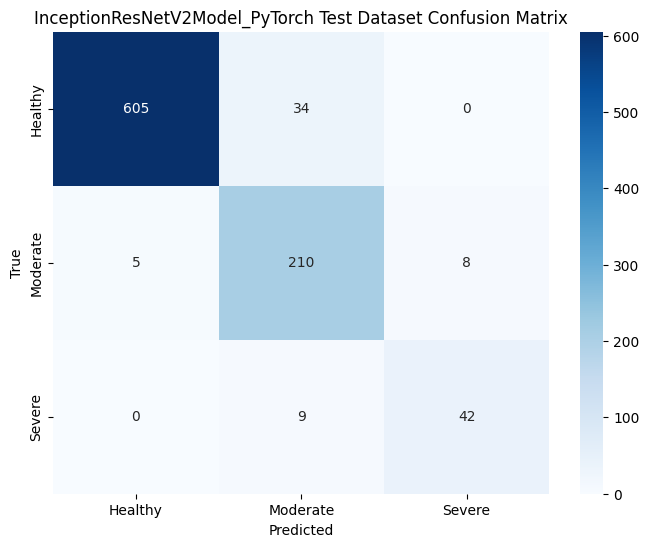

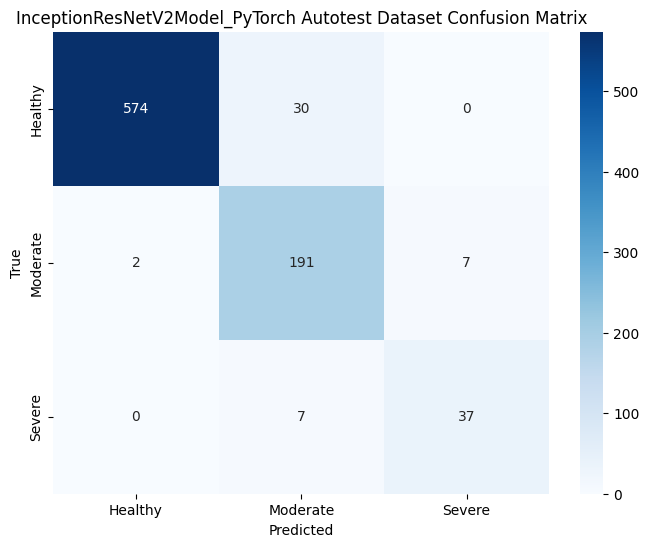

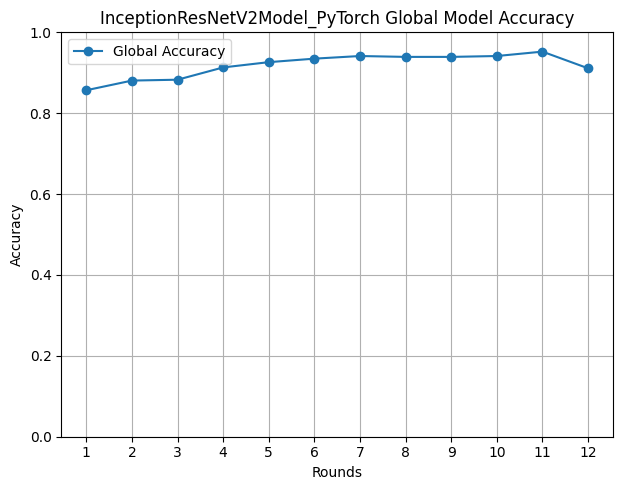

In [17]:
import warnings
warnings.filterwarnings("ignore")

def main():
    MODEL_NAME = "InceptionResNetV2Model_PyTorch"
    print(f"Using device: {DEVICE}")
    print("-" * 50)

    print("Creating client shards...")
    client_shards, client_sample_counts = create_client_shards()

    print("Creating data loaders...")
    client_loaders = create_dataloaders(client_shards, client_sample_counts)
    val_loader, test_loader, autotest_loader = load_validation_test_data()

    print("\nClient data distribution:")
    total_samples = sum(client_sample_counts)
    for i, count in enumerate(client_sample_counts):
        print(f"Client {i + 1}: {count} samples ({count / total_samples * 100:.1f}%)")

    print("\nCreating global model...")
    global_model = InceptionResNetV2Model().to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    print("\nStarting federated learning...")
    print("-" * 50)

    client_accuracies_history = []
    global_accuracies_history = []
    accuracies_df = pd.DataFrame(columns=['Round', 'Client', 'Client Accuracy', 'Global Accuracy'])

    for round_num in range(NUM_ROUNDS):
        print(f"\nRound {round_num + 1}/{NUM_ROUNDS}")
        print("-" * 30)

        client_weights = []
        round_client_accuracies = []

        for client_idx, client_loader in enumerate(client_loaders):
            print(f"Training Client {client_idx + 1}...")

            client_model = InceptionResNetV2Model().to(DEVICE)
            client_model.load_state_dict(global_model.state_dict())
            optimizer = optim.Adam(client_model.parameters(), lr=0.001)

            updated_weights, client_accuracy = client_update(
                client_model, client_loader, optimizer, criterion)

            client_weights.append(updated_weights)
            round_client_accuracies.append(client_accuracy)

            new_row = pd.DataFrame({
                'Round': [round_num + 1],
                'Client': [client_idx + 1],
                'Client Accuracy': [client_accuracy]
            })
            accuracies_df = pd.concat([accuracies_df, new_row], ignore_index=True)

            print(f"Client {client_idx + 1} Accuracy: {client_accuracy:.4f}")

        client_accuracies_history.append(round_client_accuracies)

        global_weights = weighted_average_weights(client_weights, client_sample_counts)
        global_model.load_state_dict(global_weights)

        global_accuracy, global_loss, _, _ = evaluate_model(global_model, val_loader)
        global_accuracies_history.append(global_accuracy)

        accuracies_df.loc[accuracies_df['Round'] == (round_num + 1), 'Global Accuracy'] = global_accuracy

        print("\nRound Summary:")
        print(f"Average Client Accuracy: {np.mean(round_client_accuracies):.4f}")
        print(f"Global Model Accuracy: {global_accuracy:.4f}")
        print(f"Global Model Loss: {global_loss:.4f}")
        print("-" * 30)

    # Save the global model
    torch.save(global_model.state_dict(), f"{MODEL_NAME}.pth")

    # Final evaluation
    print("\nFinal Test Results:")
    print("-" * 20)
    test_accuracy, test_loss, test_preds, test_labels = evaluate_model(global_model, test_loader)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    print("\nAutoTest Results:")
    print("-" * 20)
    autotest_accuracy, autotest_loss, autotest_preds, autotest_labels = evaluate_model(global_model, autotest_loader)
    print(f"AutoTest Accuracy: {autotest_accuracy:.4f}")
    print(f"AutoTest Loss: {autotest_loss:.4f}")

    # Classification reports
    print("\nTest dataset - Classification Report:")
    print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))

    print("\nAutotest dataset - Classification Report:")
    print(classification_report(autotest_labels, autotest_preds, target_names=CLASS_NAMES))

    # Plot confusion matrices
    def plot_confusion_matrix(true_labels, pred_labels, title, filename):
        plt.figure(figsize=(8, 6))
        conf_matrix = confusion_matrix(true_labels, pred_labels)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=CLASS_NAMES,
                    yticklabels=CLASS_NAMES)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(filename)
        plt.show()

    plot_confusion_matrix(
        test_labels, test_preds,
        f'{MODEL_NAME} Test Dataset Confusion Matrix',
        f"{MODEL_NAME}_test_confusion_matrix.png"
    )

    plot_confusion_matrix(
        autotest_labels, autotest_preds,
        f'{MODEL_NAME} Autotest Dataset Confusion Matrix',
        f"{MODEL_NAME}_autotest_confusion_matrix.png"
    )

    # Plot accuracy history
    rounds = np.arange(1, NUM_ROUNDS + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rounds, global_accuracies_history, marker='o', label='Global Accuracy')
    plt.title(f'{MODEL_NAME} Global Model Accuracy')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.xticks(rounds)
    plt.ylim([0, 1])
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{MODEL_NAME}_global_accuracy.png")
    plt.show()

    # Save accuracies DataFrame
    accuracies_df.to_csv(f"{MODEL_NAME}_accuracies.csv", index=False)

if __name__ == "__main__":
    main()
